In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from classificatiom_model import EarlyStopping, ModelSaver,train_model1,plot_learning_curves,plot_learning_loss_curves,evaluate_model
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
# 计算Fashion MNIST数据集的均值和标准差:
# mean = sum(pixel_values) / (num_images * height * width)
# std = sqrt(sum((pixel_values - mean)^2) / (num_images * height * width))
#
# Fashion MNIST数据集包含:
# - 60000张训练图片，每张28x28像素
# - 像素值范围0-255，需要除以255归一化到0-1
# - mean ≈ 0.286 = sum(all_pixels) / (60000 * 28 * 28) / 255
# - std ≈ 0.353 = sqrt(sum((pixels/255 - mean)^2) / (60000 * 28 * 28))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))  
])
# 加载FashionMNIST数据集
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)




In [2]:
# 获取训练集和测试集的图像与标签
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 打印数据集形状
print("训练集图像形状:", train_images.shape)
print("训练集标签形状:", train_labels.shape)
print("测试集图像形状:", test_images.shape) 
print("测试集标签形状:", test_labels.shape)


训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)


In [3]:
# 获取训练集和测试集的图像与标签
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 打印数据集形状
print("训练集图像形状:", train_images.shape)
print("训练集标签形状:", train_labels.shape)
print("测试集图像形状:", test_images.shape) 
print("测试集标签形状:", test_labels.shape)


训练集图像形状: (60000, 28, 28)
训练集标签形状: (60000,)
测试集图像形状: (10000, 28, 28)
测试集标签形状: (10000,)


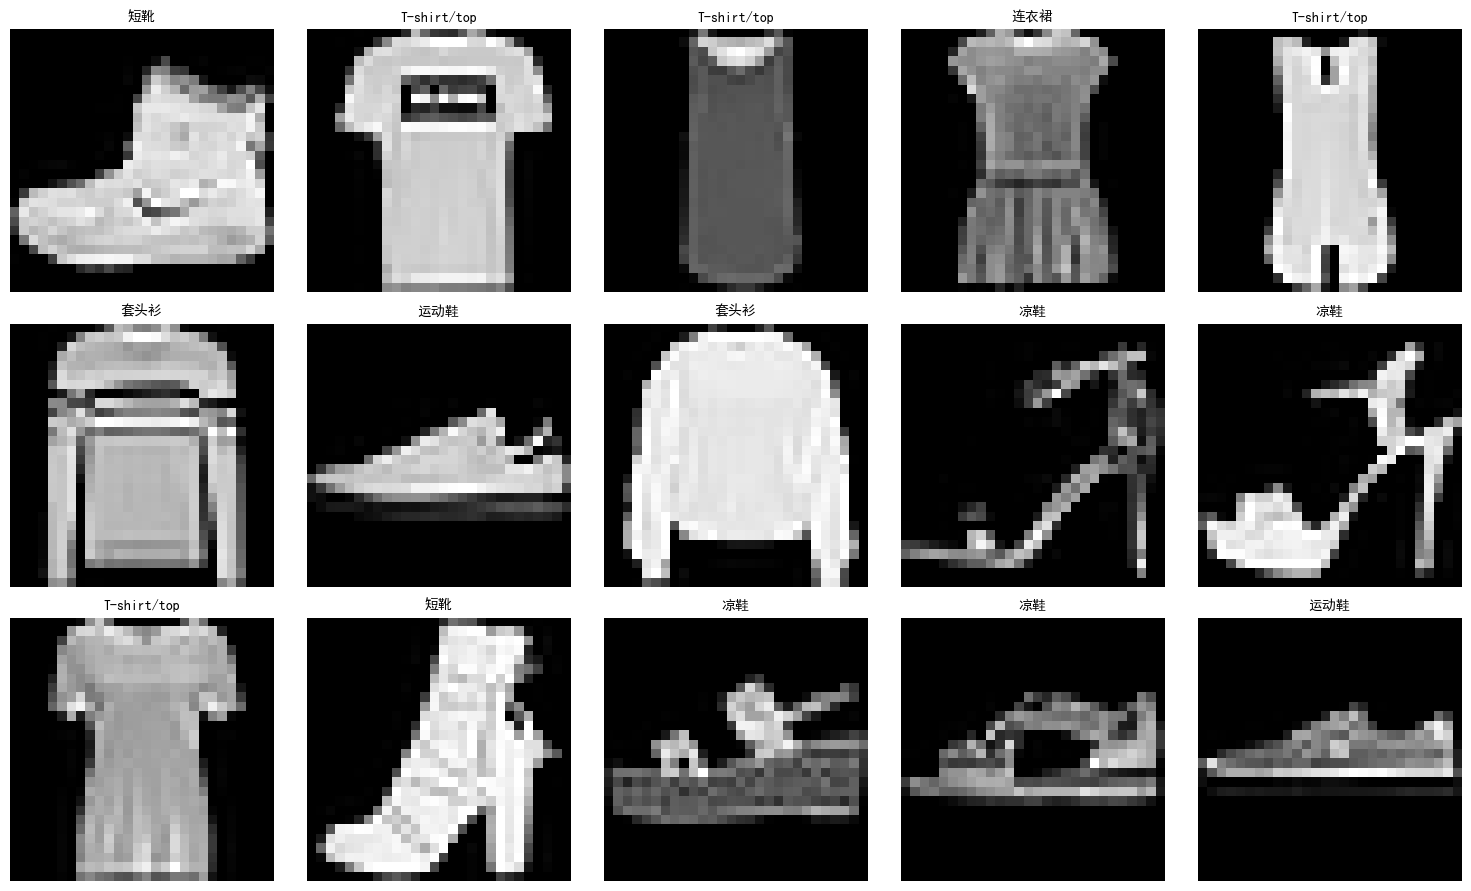

In [4]:
# 导入matplotlib用于绘图
import matplotlib.pyplot as plt
import matplotlib
# 设置中文字体，解决中文显示问题
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建一个3行5列的图表来显示前15个样本
plt.figure(figsize=(15, 9))  # 设置图表大小

# 遍历前15个样本
for i in range(15):
    # 创建子图
    plt.subplot(3, 5, i + 1)
    
    # 显示图像
    plt.imshow(train_images[i], cmap='gray')
    
    # 添加标题（显示类别名称）
    plt.title(class_names[train_labels[i]], fontsize=10)
    
    # 关闭坐标轴
    plt.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()


In [5]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_subset)}")
print(f"验证集大小: {len(val_subset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")

训练集大小: 55000
验证集大小: 5000
测试集大小: 10000
批次大小: 64
训练批次数: 860


In [6]:
import torch.nn as nn
import torch.nn.functional as F
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        # 继承父类nn.Module的初始化
        super().__init__()
        # 将输入张量从2D展平为1D
        self.flatten = nn.Flatten()
        
        # 构建一个包含多个层的Sequential容器
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 输入层 -> 第一隐藏层 (784 -> 100)
            nn.ReLU(),  # ReLU激活函数
        )
        
        # 动态添加更多隐藏层 (共添加layers_num-1层)
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))
            self.linear_relu_stack.add_module(f"BatchNorm_{i}", nn.BatchNorm1d(100))
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())
            
        # 添加输出层 (100 -> 10，对应10个类别)
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))
        
        # 初始化网络权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        # 遍历模型中的所有模块
        for m in self.modules():
            # 如果是全连接层，则初始化其权重
            if isinstance(m, nn.Linear):
                # xavier均匀分布初始化权重，有助于解决深层网络的梯度消失/爆炸问题
                nn.init.xavier_uniform_(m.weight)
                # 将偏置项初始化为0
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        # x的初始形状为 [batch_size, 1, 28, 28]
        # 将输入张量展平
        x = self.flatten(x)
        # 展平后形状为 [batch_size, 28*28]
        # 通过网络的所有层
        logits = self.linear_relu_stack(x)
        # 输出形状为 [batch_size, 10]，对应10个类别
        return logits


In [7]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)




批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])


In [8]:
# 初始化总参数量计数器
total_params = 0
print("模型参数量明细:")

# 遍历模型的所有参数
for name, param in model.named_parameters():
    # 计算当前层的参数数量
    param_count = param.numel()  # numel()返回张量中元素的总数
    # 累加到总参数量
    total_params += param_count
    # 打印当前层的名称和参数量
    print(f"{name}: {param_count:,} 参数")
print(f"\n总参数量: {total_params:,}")


模型参数量明细:
linear_relu_stack.0.weight: 78,400 参数
linear_relu_stack.0.bias: 100 参数
linear_relu_stack.Linear_1.weight: 10,000 参数
linear_relu_stack.Linear_1.bias: 100 参数
linear_relu_stack.BatchNorm_1.weight: 100 参数
linear_relu_stack.BatchNorm_1.bias: 100 参数
linear_relu_stack.Output Layer.weight: 1,000 参数
linear_relu_stack.Output Layer.bias: 10 参数

总参数量: 89,810


In [9]:
from torch.utils.tensorboard import SummaryWriter

# TensorboardLogger类用于记录深度学习训练过程中的各种指标
# 包括训练损失、准确率、验证损失、准确率、学习率等
# 这些数据可以通过Tensorboard可视化工具进行查看和分析
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录
    """
    def __init__(self, log_dir='tensorboard_logs'):
        # 导入os模块用于文件和目录操作
        import os
        
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        # 创建SummaryWriter实例，用于写入tensorboard日志
        # log_dir指定日志文件保存的位置
        self.writer = SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘
        
    def log_training(self, epoch, train_loss, train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        # add_scalar方法用于记录标量值
        # 第一个参数是指标名称，第二个参数是具体值，第三个参数是步数/轮数
        self.writer.add_scalar('训练/损失', train_loss, epoch)
        self.writer.add_scalar('训练/准确率', train_acc, epoch)
        
    def log_validation(self, epoch, val_loss, val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        # 记录验证集上的损失和准确率
        self.writer.add_scalar('验证/损失', val_loss, epoch)
        self.writer.add_scalar('验证/准确率', val_acc, epoch)
    
    def log_lr(self, epoch, lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        # 记录当前的学习率
        self.writer.add_scalar('学习率', lr, epoch)
        
    def log_model_graph(self, model, images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """
        # add_graph方法用于可视化模型结构
        # 需要传入模型实例和一个输入样本
        self.writer.add_graph(model, images)
        
    def close(self):
        """
        关闭Tensorboard写入器
        """
        # 关闭writer，确保所有数据都已写入磁盘
        self.writer.close()


In [10]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器

print("损失函数:", criterion)
print("优化器:", optimizer)


损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)
tensorboard_logger=TensorboardLogger(log_dir='logs')

model, history = train_model1(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=tensorboard_logger)

使用设备: cuda:0


Training Progress:   0%|          | 0/43000 [00:00<?, ?it/s]

早停触发! 最佳验证准确率: 89.2200
早停: 已有5轮验证损失没有改善！


In [12]:
history['train'][-100:-1]

[{'loss': 0.12364839017391205, 'acc': 96.875, 'step': 9901},
 {'loss': 0.18129557371139526, 'acc': 93.75, 'step': 9902},
 {'loss': 0.20439238846302032, 'acc': 90.625, 'step': 9903},
 {'loss': 0.100779227912426, 'acc': 98.4375, 'step': 9904},
 {'loss': 0.24612751603126526, 'acc': 92.1875, 'step': 9905},
 {'loss': 0.17787714302539825, 'acc': 93.75, 'step': 9906},
 {'loss': 0.17153216898441315, 'acc': 93.75, 'step': 9907},
 {'loss': 0.34730708599090576, 'acc': 87.5, 'step': 9908},
 {'loss': 0.2548972964286804, 'acc': 87.5, 'step': 9909},
 {'loss': 0.1228334978222847, 'acc': 98.4375, 'step': 9910},
 {'loss': 0.13924086093902588, 'acc': 95.3125, 'step': 9911},
 {'loss': 0.2031477838754654, 'acc': 92.1875, 'step': 9912},
 {'loss': 0.2254946082830429, 'acc': 89.0625, 'step': 9913},
 {'loss': 0.20179475843906403, 'acc': 92.1875, 'step': 9914},
 {'loss': 0.19344976544380188, 'acc': 93.75, 'step': 9915},
 {'loss': 0.3335859775543213, 'acc': 85.9375, 'step': 9916},
 {'loss': 0.21948198974132538, 

In [13]:
history['val'][-1000:-1]

[{'loss': 2.452783575439453, 'acc': 9.02, 'step': 0},
 {'loss': 0.42870310678482054, 'acc': 85.02, 'step': 500},
 {'loss': 0.39092973985671997, 'acc': 85.82, 'step': 1000},
 {'loss': 0.3659090235710144, 'acc': 86.64, 'step': 1500},
 {'loss': 0.3568580757141113, 'acc': 86.62, 'step': 2000},
 {'loss': 0.34316108129024503, 'acc': 87.48, 'step': 2500},
 {'loss': 0.33484742398262024, 'acc': 87.72, 'step': 3000},
 {'loss': 0.3351352785587311, 'acc': 88.06, 'step': 3500},
 {'loss': 0.34343748047351835, 'acc': 87.58, 'step': 4000},
 {'loss': 0.33328326811790465, 'acc': 87.7, 'step': 4500},
 {'loss': 0.3263505717873573, 'acc': 88.26, 'step': 5000},
 {'loss': 0.34884267857074736, 'acc': 87.5, 'step': 5500},
 {'loss': 0.3374317555487156, 'acc': 87.72, 'step': 6000},
 {'loss': 0.3409785583496094, 'acc': 88.16, 'step': 6500},
 {'loss': 0.3318889343738556, 'acc': 88.54, 'step': 7000},
 {'loss': 0.31059598760604856, 'acc': 89.22, 'step': 7500},
 {'loss': 0.3281207996845245, 'acc': 88.46, 'step': 8000

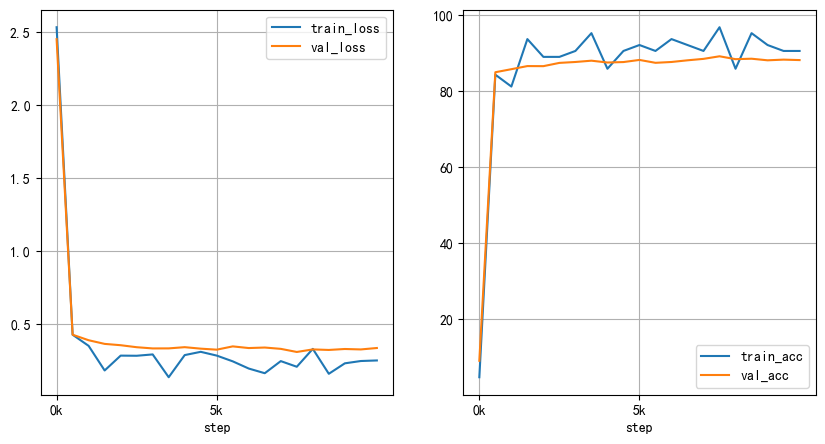

In [15]:
plot_learning_curves(history, sample_step=500)


In [16]:

# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device)
test_accuracy

87.97